In [305]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [306]:
def data_upload(folder_path_name):
    
    folder_path = str(folder_path_name)
    datasets = []
    datasets_dict = {} # access via file name possible
    numbers_of_rows = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            print(f"Processing file: {file_path}")
            
            df = pd.read_csv(file_path).drop('frame', axis=1)

            filename_lower = filename.lower()
            print(f"Normalized filename: {filename_lower}")

            if 'abnormal' in str(filename_lower):
                df['label'] = 1  # Label 0 for 'normal'
            elif 'normal' in str(filename_lower):
                df['label'] = 0  # Label 1 for 'abnormal'
            else:
                print("No label attached")
            
        
            datasets.append(df)
            datasets_dict[filename] = df
            numbers_of_rows.append(df.shape[0])
            
    
    return datasets, datasets_dict, numbers_of_rows, pd.concat(datasets, axis=0)


In [308]:
DS, DS_dict, number_of_rows, df = data_upload('vertical')

Processing file: vertical/dark_fast_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted.csv
Normalized filename: dark_fast_15fps_270_postural reflexes, landau reflex, 6 months, normal.csv_frameskip_noise_inverted.csv
Processing file: vertical/slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv
Normalized filename: slow_15fps_180_primitve reflexes, galant reflex, newborn normal.csv_framedup_inverted.csv
Processing file: vertical/bright_slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_inverted.csv
Normalized filename: bright_slow_15fps_90_primitive reflex, galant reflex, 3 months, normal.csv_framedup_inverted.csv
Processing file: vertical/270_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Normalized filename: 270_15fps_slow_bright_rar_verticalsus_abnormal.csv_frameskip_noise.csv
Processing file: vertical/15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.cs

In [309]:
from sklearn.preprocessing import normalize

def pre_processing(df_concatenated, window_size = 15):

    df = df_concatenated.copy()
    columns_to_process = [col for col in df.columns if not any(col == f'{i}_cs' for i in range(33))]

    df = df.dropna(subset=columns_to_process, how='all')
    df[columns_to_process] = df[columns_to_process].interpolate(method='linear', axis=1)
    df = df.fillna(df.mean()) 

    for col in columns_to_process:
        df[col] = df[col].rolling(window=window_size, center=True, min_periods=1).median()
        df[col] = df[col].rolling(window=window_size, center=True, min_periods=1).mean()
    
    cols_to_normalize = [col for col in df.columns if 'cs' not in col]

    df_normalized = df.copy()
    df_normalized[cols_to_normalize] = normalize(df[cols_to_normalize], norm='l2')

    df_joints_cols = [col for col in df.columns if 'cs' in col]
    df_joints = df[df_joints_cols]
        

    return df, df_joints

In [310]:
df_prepocessed, df_joints = pre_processing(df)

In [311]:
def significance_test(df_joints, threshold = 0.5):
    t_all = []
    index = []
    n = len(df_joints)
    for i, joint in enumerate(df_joints):
        t = (np.sum(df_joints[joint])/n) * 0.95
        if t < threshold:
            index.append(i)
        t_all.append(t)
    return t_all, index

def visualize_histogram(df_joints, threshold = 0.5, if_plot = True):

    data, index_to_remove = significance_test(df_joints, threshold)  # Zastąp to odpowiednią funkcją lub zmienną

    if if_plot:
        sns.set_palette('pastel')  
        plt.figure(figsize=(8, 5))
        ax = sns.histplot(data, kde=False, bins=10)

        plt.title('Histogram of Confidence Score', fontsize=16)
        plt.xlabel('Confidence Score for Joint', fontsize=12)
        plt.ylabel('Joint count', fontsize=12)

        for p in ax.patches:
            height = p.get_height()
            if height > 0:  # Pomijamy zera
                ax.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height), 
                            ha='center', va='center', fontsize=12, color='black', xytext=(0, 6),
                            textcoords='offset points')
        plt.axvline(threshold, color = 'r')
        plt.show()
    
    return data, index_to_remove

In [313]:
_, index_to_remove = significance_test(df_joints, threshold = 0.5)

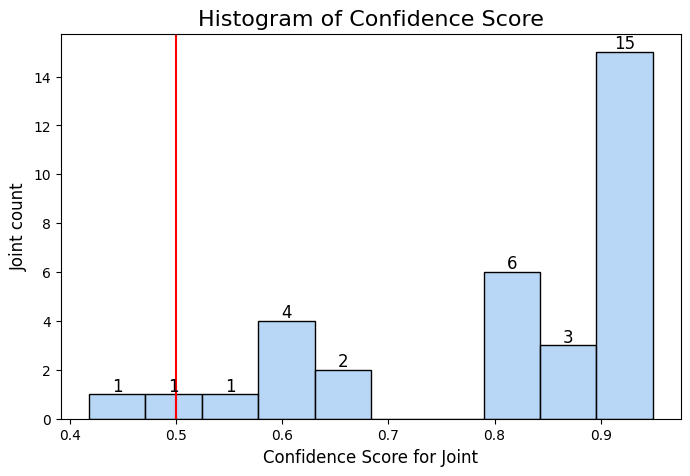

([0.9481333877391637,
  0.9481996845370952,
  0.9481940294950777,
  0.9481513074093826,
  0.9478091285211745,
  0.9474722954783064,
  0.9479613450378944,
  0.9475367890810251,
  0.9473841876281787,
  0.9463052500210926,
  0.9460799472784776,
  0.9488197084684011,
  0.9490153257198594,
  0.8861797004106181,
  0.4179309617056281,
  0.8609706454903,
  0.5742271135345044,
  0.8363167022717541,
  0.5788658617081487,
  0.8362834967669732,
  0.5863933719449081,
  0.8129515256281151,
  0.5885203510209961,
  0.9482039056030653,
  0.9478456873821219,
  0.8540536690583799,
  0.5046260593922619,
  0.8318779630667753,
  0.6221544898107594,
  0.8100671843120298,
  0.6663670667328189,
  0.815983368074127,
  0.6511973158195093],
 [14])

In [314]:
visualize_histogram(df_joints, threshold = 0.5, if_plot = True)

In [315]:
def data_save(df, number_of_rows, indexes_to_remove, folder_path_name, output_folder):
    folder_path = str(folder_path_name)
    output_folder = str(output_folder)

    # Pobieramy wszystkie pliki CSV z folderu
    filenames = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

    # Upewnijmy się, że długości filenames i number_of_rows są zgodne
    if len(filenames) != len(number_of_rows):
        print(len(filenames), len(number_of_rows))
        raise ValueError("Liczba plików CSV musi być równa długości listy number_of_rows.")

    concatenated_df = df # Upewnij się, że df jest zdefiniowane wcześniej
    source_files = []

    # Dla każdego pliku i liczby wierszy przypisujemy nazwę pliku odpowiednią liczbę razy
    for i, rows in enumerate(number_of_rows):
        source_files.extend([filenames[i]] * rows)

    # Dodajemy kolumnę 'source_file' do DataFrame
    concatenated_df['source_file'] = source_files
    grouped = concatenated_df.groupby('source_file')

    # Przetwarzamy dane
    for file_name, group_df in grouped:
        for idx in indexes_to_remove:
            columns_to_modify = [col for col in group_df.columns if str(idx) in col]
            for col in columns_to_modify:
                group_df[col] = None

        # Usuwamy kolumny, które zawierają cyfry oraz '_cs'
        group_df = group_df.loc[:, ~group_df.columns.str.contains(r'\d+_cs')]

        # Zapisujemy grupę do pliku w folderze wyjściowym
        output_file_path = os.path.join(output_folder, file_name)
        group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
        group_df.to_csv(output_file_path, index=False)
        print(f"Zapisano: {output_file_path}")


In [317]:
data_save(df_prepocessed, number_of_rows, indexes_to_remove, folder_path_name = 'vertical', output_folder = 'output_vertical')

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  concatenated_df['source_file'] = source_files
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats i

Zapisano: output_vertical/15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/15fps_180_Postural Reflexes, Landau Ref

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/15fps_180_Primitive Reflex, Galant Reflex, 3 M

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise.csv
Zapisano: output_vertical/15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup.csv
Zapisano: output_vertical/15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'


Zapisano: output_vertical/15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise.csv
Zapisano: output_vertical/15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'


Zapisano: output_vertical/15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv
Zapisano: output_vertical/15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_inverted.csv
Zapisano: output_vertical/15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise.csv
Zapisano: output_vertical/15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_180_Ventral Suspension, 3 Months, normal.csv_framedup.csv
Zapisano: output_vertical/15fps_180_Ventral Suspension, 3 Months, normal.csv_framedup_inverted.csv
Zapisano: output_vertical/15fps_180_Ventral Suspension, 3 Months, normal.csv_framedup_noise.csv
Zapisano: output_vertical/15fps_180_Ventral Suspension, 3 Months, normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip.csv
Zapisano: output_vertical/15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_noise.csv
Zapisano: output_vertical/15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/15fps_180_Ventral Suspension, 3 Months, normal.csv_inverted.csv
Zapisano: output_vertical/15fps_180_Ventral Suspension, 3 Months, normal.csv_noise.csv
Zapisano: output_vertical/15fps_180_Ventral Suspension, 3 Months, normal.csv_noise_inverted.csv
Zapisano: output_vertical/15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise.csv
Zapisano: output_vertical/15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'


Zapisano: output_vertical/15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup.csv
Zapisano: output_vertical/15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise.csv
Zapisano: output_vertical/15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise.csv
Zapisano: output_vertical/15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise_inverted.csv
Zapisano: output_vertical/15fps_270_Ventral Suspension, 3 Months, normal.csv_framedup.csv
Zapisano: output_vertical/15fps_270_Ventral Suspension, 3 Months, normal.csv_framedup_inverted.csv
Zapisano: output_vertical/15fps_270_Ventral Suspension, 3 Months, normal.csv_framedup_noise.csv
Zapisano: output_vertical/15fps_270_Ventral Suspension, 3 Months, normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_noise.csv
Zapisano: output_vertical/15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/15fps_270_Ventral Suspension, 3 Months, normal.csv_inverted.csv
Zapisano: output_vertical/15fps_270_Ventral Suspension, 3 Months, normal.csv_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_270_Ventral Suspension, 3 Months, normal.csv_noise_inverted.csv
Zapisano: output_vertical/15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise.csv
Zapisano: output_vertical/15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise.csv
Zapisano: output_vertical/15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup.csv
Zapisano: output_vertical/15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise.csv
Zapisano: output_vertical/15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv
Zapisano: output_vertical/15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_inverted.csv
Zapisano: output_vertical/15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise.csv
Zapisano: output_vertical/15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_90_Ventral Suspension, 3 Months, normal.csv_framedup.csv
Zapisano: output_vertical/15fps_90_Ventral Suspension, 3 Months, normal.csv_framedup_inverted.csv
Zapisano: output_vertical/15fps_90_Ventral Suspension, 3 Months, normal.csv_framedup_noise.csv
Zapisano: output_vertical/15fps_90_Ventral Suspension, 3 Months, normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip.csv
Zapisano: output_vertical/15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_noise.csv
Zapisano: output_vertical/15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/15fps_90_Ventral Suspension, 3 Months, normal.csv_inverted.csv
Zapisano: output_vertical/15fps_90_Ventral Suspension, 3 Months, normal.csv_noise.csv
Zapisano: output_vertical/15fps_90_Ventral Suspension, 3 Months, normal.csv_noise_inverted.csv
Zapisano: output_vertical/15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise.csv
Zapisano: output_vertical/15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise.csv
Zapisano: output_vertical/15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup.csv
Zapisano: output_vertical/15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv
Zapisano: output_vertical/15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_inverted.csv
Zapisano: output_vertical/15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise.csv
Zapisano: output_vertical/15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise_inverted.csv
Zapisano: output_vertical/15fps_RaR_Verticalsus_ABnormal.csv_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv
Zapisano: output_vertical/15fps_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv
Zapisano: output_vertical/15fps_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_RaR_Verticalsus_ABnormal.csv_frameskip.csv
Zapisano: output_vertical/15fps_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/15fps_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/15fps_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv
Zapisano: output_vertical/15fps_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Zapisano: output_vertical/15fps_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/15fps_RaR_Verticalsus_ABnormal.csv_noise.csv
Zapisano: output_vertical/15fps_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv
Zapisano: output_vertical/15fps_Ventral Suspension, 3 Months, normal.csv_framedup.csv
Zapisano: output_vertical/15fps_Ventral Suspension, 3 Months, normal.csv_framedup_inverted.csv
Zapisano: output_vertical/15fps_Ventral Suspension, 3 Months, normal.csv_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_Ventral Suspension, 3 Months, normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_Ventral Suspension, 3 Months, normal.csv_frameskip.csv
Zapisano: output_vertical/15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_noise.csv
Zapisano: output_vertical/15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/15fps_Ventral Suspension, 3 Months, normal.csv_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_Ventral Suspension, 3 Months, normal.csv_noise.csv
Zapisano: output_vertical/15fps_Ventral Suspension, 3 Months, normal.csv_noise_inverted.csv
Zapisano: output_vertical/15fps_bright_RaR_Verticalsus_ABnormal.csv_framedup.csv
Zapisano: output_vertical/15fps_bright_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv
Zapisano: output_vertical/15fps_bright_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_bright_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_bright_RaR_Verticalsus_ABnormal.csv_frameskip.csv
Zapisano: output_vertical/15fps_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv
Zapisano: output_vertical/15fps_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/15fps_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/15fps_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_bright_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv
Zapisano: output_vertical/15fps_bright_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Zapisano: output_vertical/15fps_bright_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/15fps_bright_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/15fps_bright_RaR_Verticalsus_ABnormal.csv_noise.csv
Zapisano: output_vertical/15fps_bright_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_dark_RaR_Verticalsus_ABnormal.csv_framedup.csv
Zapisano: output_vertical/15fps_dark_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv
Zapisano: output_vertical/15fps_dark_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv
Zapisano: output_vertical/15fps_dark_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_dark_RaR_Verticalsus_ABnormal.csv_frameskip.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv
Zapisano: output_vertical/15fps_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/15fps_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/15fps_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_dark_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv
Zapisano: output_vertical/15fps_dark_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_dark_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/15fps_dark_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/15fps_dark_RaR_Verticalsus_ABnormal.csv_noise.csv
Zapisano: output_vertical/15fps_dark_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv
Zapisano: output_vertical/15fps_fast_RaR_Verticalsus_ABnormal.csv_framedup.csv
Zapisano: output_vertical/15fps_fast_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_fast_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv
Zapisano: output_vertical/15fps_fast_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_fast_RaR_Verticalsus_ABnormal.csv_frameskip.csv
Zapisano: output_vertical/15fps_fast_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv
Zapisano: output_vertical/15fps_fast_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/15fps_fast_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/15fps_fast_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_fast_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv
Zapisano: output_vertical/15fps_fast_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Zapisano: output_vertical/15fps_fast_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_fast_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/15fps_fast_RaR_Verticalsus_ABnormal.csv_noise.csv
Zapisano: output_vertical/15fps_fast_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv
Zapisano: output_vertical/15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_framedup.csv
Zapisano: output_vertical/15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv
Zapisano: output_vertical/15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv
Zapisano: output_vertical/15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_frameskip.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv
Zapisano: output_vertical/15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv
Zapisano: output_vertical/15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Zapisano: output_vertical/15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_noise.csv
Zapisano: output_vertical/15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_framedup.csv
Zapisano: output_vertical/15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv
Zapisano: output_vertical/15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv
Zapisano: output_vertical/15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_frameskip.csv
Zapisano: output_vertical/15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv
Zapisano: output_vertical/15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv
Zapisano: output_vertical/15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Zapisano: output_vertical/15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_noise.csv
Zapisano: output_vertical/15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_slow_RaR_Verticalsus_ABnormal.csv_framedup.csv
Zapisano: output_vertical/15fps_slow_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'


Zapisano: output_vertical/15fps_slow_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv
Zapisano: output_vertical/15fps_slow_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_slow_RaR_Verticalsus_ABnormal.csv_frameskip.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_slow_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv
Zapisano: output_vertical/15fps_slow_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/15fps_slow_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_slow_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_slow_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv
Zapisano: output_vertical/15fps_slow_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Zapisano: output_vertical/15fps_slow_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_slow_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/15fps_slow_RaR_Verticalsus_ABnormal.csv_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'


Zapisano: output_vertical/15fps_slow_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv
Zapisano: output_vertical/15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'


Zapisano: output_vertical/15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv
Zapisano: output_vertical/15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'


Zapisano: output_vertical/15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_frameskip.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'


Zapisano: output_vertical/15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv
Zapisano: output_vertical/15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv
Zapisano: output_vertical/15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Zapisano: output_vertical/15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_noise.csv
Zapisano: output_vertical/15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_framedup.csv
Zapisano: output_vertical/15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'


Zapisano: output_vertical/15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv
Zapisano: output_vertical/15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_frameskip.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv
Zapisano: output_vertical/15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv
Zapisano: output_vertical/15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Zapisano: output_vertical/15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_noise.csv
Zapisano: output_vertical/15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/180_15fps_RaR_Verticalsus_ABnormal.csv_framedup.csv
Zapisano: output_vertical/180_15fps_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv
Zapisano: output_vertical/180_15fps_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv
Zapisano: output_vertical/180_15fps_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/180_15fps_RaR_Verticalsus_ABnormal.csv_frameskip.csv
Zapisano: output_vertical/180_15fps_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv
Zapisano: output_vertical/180_15fps_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/180_15fps_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/180_15fps_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/180_15fps_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv
Zapisano: output_vertical/180_15fps_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Zapisano: output_vertical/180_15fps_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/180_15fps_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/180_15fps_RaR_Verticalsus_ABnormal.csv_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/180_15fps_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv
Zapisano: output_vertical/180_15fps_bright_RaR_Verticalsus_ABnormal.csv_framedup.csv
Zapisano: output_vertical/180_15fps_bright_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv
Zapisano: output_vertical/180_15fps_bright_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/180_15fps_bright_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/180_15fps_bright_RaR_Verticalsus_ABnormal.csv_frameskip.csv
Zapisano: output_vertical/180_15fps_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv
Zapisano: output_vertical/180_15fps_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/180_15fps_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/180_15fps_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/180_15fps_bright_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv
Zapisano: output_vertical/180_15fps_bright_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Zapisano: output_vertical/180_15fps_bright_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/180_15fps_bright_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/180_15fps_bright_RaR_Verticalsus_ABnormal.csv_noise.csv
Zapisano: output_vertical/180_15fps_bright_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/180_15fps_dark_RaR_Verticalsus_ABnormal.csv_framedup.csv
Zapisano: output_vertical/180_15fps_dark_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv
Zapisano: output_vertical/180_15fps_dark_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv
Zapisano: output_vertical/180_15fps_dark_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/180_15fps_dark_RaR_Verticalsus_ABnormal.csv_frameskip.csv
Zapisano: output_vertical/180_15fps_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv
Zapisano: output_vertical/180_15fps_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/180_15fps_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/180_15fps_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/180_15fps_dark_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/180_15fps_dark_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Zapisano: output_vertical/180_15fps_dark_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/180_15fps_dark_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/180_15fps_dark_RaR_Verticalsus_ABnormal.csv_noise.csv
Zapisano: output_vertical/180_15fps_dark_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/180_15fps_fast_RaR_Verticalsus_ABnormal.csv_framedup.csv
Zapisano: output_vertical/180_15fps_fast_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv
Zapisano: output_vertical/180_15fps_fast_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv
Zapisano: output_vertical/180_15fps_fast_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/180_15fps_fast_RaR_Verticalsus_ABnormal.csv_frameskip.csv
Zapisano: output_vertical/180_15fps_fast_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv
Zapisano: output_vertical/180_15fps_fast_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/180_15fps_fast_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/180_15fps_fast_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/180_15fps_fast_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv
Zapisano: output_vertical/180_15fps_fast_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Zapisano: output_vertical/180_15fps_fast_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/180_15fps_fast_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/180_15fps_fast_RaR_Verticalsus_ABnormal.csv_noise.csv
Zapisano: output_vertical/180_15fps_fast_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv
Zapisano: output_vertical/180_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_framedup.csv
Zapisano: output_vertical/180_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/180_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv
Zapisano: output_vertical/180_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/180_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_frameskip.csv
Zapisano: output_vertical/180_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv
Zapisano: output_vertical/180_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/180_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/180_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/180_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv
Zapisano: output_vertical/180_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/180_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/180_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/180_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_noise.csv
Zapisano: output_vertical/180_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv
Zapisano: output_vertical/180_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_framedup.csv
Zapisano: output_vertical/180_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv
Zapisano: output_vertical/180_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv
Zapisano: output_vertical/180_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/180_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_frameskip.csv
Zapisano: output_vertical/180_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv
Zapisano: output_vertical/180_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/180_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/180_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/180_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv
Zapisano: output_vertical/180_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Zapisano: output_vertical/180_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/180_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/180_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/180_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv
Zapisano: output_vertical/180_15fps_slow_RaR_Verticalsus_ABnormal.csv_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'


Zapisano: output_vertical/180_15fps_slow_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv
Zapisano: output_vertical/180_15fps_slow_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'


Zapisano: output_vertical/180_15fps_slow_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/180_15fps_slow_RaR_Verticalsus_ABnormal.csv_frameskip.csv
Zapisano: output_vertical/180_15fps_slow_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/180_15fps_slow_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/180_15fps_slow_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/180_15fps_slow_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/180_15fps_slow_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv
Zapisano: output_vertical/180_15fps_slow_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Zapisano: output_vertical/180_15fps_slow_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/180_15fps_slow_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/180_15fps_slow_RaR_Verticalsus_ABnormal.csv_noise.csv
Zapisano: output_vertical/180_15fps_slow_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/180_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_framedup.csv
Zapisano: output_vertical/180_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'


Zapisano: output_vertical/180_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv
Zapisano: output_vertical/180_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/180_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_frameskip.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/180_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv
Zapisano: output_vertical/180_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/180_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/180_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/180_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv
Zapisano: output_vertical/180_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Zapisano: output_vertical/180_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/180_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/180_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_noise.csv
Zapisano: output_vertical/180_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/180_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_framedup.csv
Zapisano: output_vertical/180_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'


Zapisano: output_vertical/180_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv
Zapisano: output_vertical/180_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/180_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_frameskip.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/180_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv
Zapisano: output_vertical/180_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/180_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/180_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/180_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv
Zapisano: output_vertical/180_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Zapisano: output_vertical/180_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/180_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/180_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_noise.csv
Zapisano: output_vertical/180_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/270_15fps_RaR_Verticalsus_ABnormal.csv_framedup.csv
Zapisano: output_vertical/270_15fps_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv
Zapisano: output_vertical/270_15fps_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv
Zapisano: output_vertical/270_15fps_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/270_15fps_RaR_Verticalsus_ABnormal.csv_frameskip.csv
Zapisano: output_vertical/270_15fps_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv
Zapisano: output_vertical/270_15fps_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/270_15fps_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/270_15fps_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/270_15fps_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/270_15fps_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Zapisano: output_vertical/270_15fps_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/270_15fps_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/270_15fps_RaR_Verticalsus_ABnormal.csv_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/270_15fps_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv
Zapisano: output_vertical/270_15fps_bright_RaR_Verticalsus_ABnormal.csv_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'


Zapisano: output_vertical/270_15fps_bright_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv
Zapisano: output_vertical/270_15fps_bright_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'


Zapisano: output_vertical/270_15fps_bright_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/270_15fps_bright_RaR_Verticalsus_ABnormal.csv_frameskip.csv
Zapisano: output_vertical/270_15fps_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/270_15fps_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/270_15fps_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/270_15fps_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/270_15fps_bright_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv
Zapisano: output_vertical/270_15fps_bright_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Zapisano: output_vertical/270_15fps_bright_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/270_15fps_bright_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/270_15fps_bright_RaR_Verticalsus_ABnormal.csv_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/270_15fps_bright_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv
Zapisano: output_vertical/270_15fps_dark_RaR_Verticalsus_ABnormal.csv_framedup.csv
Zapisano: output_vertical/270_15fps_dark_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv
Zapisano: output_vertical/270_15fps_dark_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/270_15fps_dark_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/270_15fps_dark_RaR_Verticalsus_ABnormal.csv_frameskip.csv
Zapisano: output_vertical/270_15fps_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv
Zapisano: output_vertical/270_15fps_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/270_15fps_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/270_15fps_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/270_15fps_dark_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv
Zapisano: output_vertical/270_15fps_dark_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Zapisano: output_vertical/270_15fps_dark_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/270_15fps_dark_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/270_15fps_dark_RaR_Verticalsus_ABnormal.csv_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/270_15fps_dark_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv
Zapisano: output_vertical/270_15fps_fast_RaR_Verticalsus_ABnormal.csv_framedup.csv
Zapisano: output_vertical/270_15fps_fast_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv
Zapisano: output_vertical/270_15fps_fast_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv
Zapisano: output_vertical/270_15fps_fast_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/270_15fps_fast_RaR_Verticalsus_ABnormal.csv_frameskip.csv
Zapisano: output_vertical/270_15fps_fast_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv
Zapisano: output_vertical/270_15fps_fast_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/270_15fps_fast_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/270_15fps_fast_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/270_15fps_fast_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv
Zapisano: output_vertical/270_15fps_fast_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Zapisano: output_vertical/270_15fps_fast_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/270_15fps_fast_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/270_15fps_fast_RaR_Verticalsus_ABnormal.csv_noise.csv
Zapisano: output_vertical/270_15fps_fast_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv
Zapisano: output_vertical/270_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/270_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv
Zapisano: output_vertical/270_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv
Zapisano: output_vertical/270_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/270_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_frameskip.csv
Zapisano: output_vertical/270_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv
Zapisano: output_vertical/270_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/270_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/270_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/270_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/270_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Zapisano: output_vertical/270_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/270_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/270_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_noise.csv
Zapisano: output_vertical/270_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv
Zapisano: output_vertical/270_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_framedup.csv
Zapisano: output_vertical/270_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv
Zapisano: output_vertical/270_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/270_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/270_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_frameskip.csv
Zapisano: output_vertical/270_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv
Zapisano: output_vertical/270_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/270_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/270_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/270_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv
Zapisano: output_vertical/270_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Zapisano: output_vertical/270_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/270_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/270_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_noise.csv
Zapisano: output_vertical/270_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv
Zapisano: output_vertical/270_15fps_slow_RaR_Verticalsus_ABnormal.csv_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/270_15fps_slow_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv
Zapisano: output_vertical/270_15fps_slow_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'


Zapisano: output_vertical/270_15fps_slow_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/270_15fps_slow_RaR_Verticalsus_ABnormal.csv_frameskip.csv
Zapisano: output_vertical/270_15fps_slow_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/270_15fps_slow_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/270_15fps_slow_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/270_15fps_slow_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/270_15fps_slow_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv
Zapisano: output_vertical/270_15fps_slow_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Zapisano: output_vertical/270_15fps_slow_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/270_15fps_slow_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/270_15fps_slow_RaR_Verticalsus_ABnormal.csv_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'


Zapisano: output_vertical/270_15fps_slow_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv
Zapisano: output_vertical/270_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'


Zapisano: output_vertical/270_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv
Zapisano: output_vertical/270_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'


Zapisano: output_vertical/270_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/270_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_frameskip.csv
Zapisano: output_vertical/270_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/270_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/270_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/270_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/270_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv
Zapisano: output_vertical/270_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Zapisano: output_vertical/270_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/270_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/270_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_noise.csv
Zapisano: output_vertical/270_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/270_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_framedup.csv
Zapisano: output_vertical/270_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'


Zapisano: output_vertical/270_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv
Zapisano: output_vertical/270_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/270_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_frameskip.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/270_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv
Zapisano: output_vertical/270_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'


Zapisano: output_vertical/270_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/270_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/270_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/270_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Zapisano: output_vertical/270_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/270_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'


Zapisano: output_vertical/270_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_noise.csv
Zapisano: output_vertical/270_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv
Zapisano: output_vertical/90_15fps_RaR_Verticalsus_ABnormal.csv_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/90_15fps_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv
Zapisano: output_vertical/90_15fps_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv
Zapisano: output_vertical/90_15fps_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/90_15fps_RaR_Verticalsus_ABnormal.csv_frameskip.csv
Zapisano: output_vertical/90_15fps_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/90_15fps_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/90_15fps_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/90_15fps_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/90_15fps_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv
Zapisano: output_vertical/90_15fps_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Zapisano: output_vertical/90_15fps_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/90_15fps_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/90_15fps_RaR_Verticalsus_ABnormal.csv_noise.csv
Zapisano: output_vertical/90_15fps_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv
Zapisano: output_vertical/90_15fps_bright_RaR_Verticalsus_ABnormal.csv_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/90_15fps_bright_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv
Zapisano: output_vertical/90_15fps_bright_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv
Zapisano: output_vertical/90_15fps_bright_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/90_15fps_bright_RaR_Verticalsus_ABnormal.csv_frameskip.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/90_15fps_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv
Zapisano: output_vertical/90_15fps_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/90_15fps_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/90_15fps_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/90_15fps_bright_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv
Zapisano: output_vertical/90_15fps_bright_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Zapisano: output_vertical/90_15fps_bright_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/90_15fps_bright_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/90_15fps_bright_RaR_Verticalsus_ABnormal.csv_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/90_15fps_bright_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv
Zapisano: output_vertical/90_15fps_dark_RaR_Verticalsus_ABnormal.csv_framedup.csv
Zapisano: output_vertical/90_15fps_dark_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/90_15fps_dark_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv
Zapisano: output_vertical/90_15fps_dark_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/90_15fps_dark_RaR_Verticalsus_ABnormal.csv_frameskip.csv
Zapisano: output_vertical/90_15fps_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/90_15fps_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/90_15fps_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/90_15fps_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/90_15fps_dark_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv
Zapisano: output_vertical/90_15fps_dark_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/90_15fps_dark_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/90_15fps_dark_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/90_15fps_dark_RaR_Verticalsus_ABnormal.csv_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/90_15fps_dark_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv
Zapisano: output_vertical/90_15fps_fast_RaR_Verticalsus_ABnormal.csv_framedup.csv
Zapisano: output_vertical/90_15fps_fast_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv
Zapisano: output_vertical/90_15fps_fast_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv
Zapisano: output_vertical/90_15fps_fast_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/90_15fps_fast_RaR_Verticalsus_ABnormal.csv_frameskip.csv
Zapisano: output_vertical/90_15fps_fast_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/90_15fps_fast_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/90_15fps_fast_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/90_15fps_fast_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/90_15fps_fast_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv
Zapisano: output_vertical/90_15fps_fast_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Zapisano: output_vertical/90_15fps_fast_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/90_15fps_fast_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/90_15fps_fast_RaR_Verticalsus_ABnormal.csv_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/90_15fps_fast_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv
Zapisano: output_vertical/90_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_framedup.csv
Zapisano: output_vertical/90_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv
Zapisano: output_vertical/90_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv
Zapisano: output_vertical/90_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/90_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_frameskip.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/90_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv
Zapisano: output_vertical/90_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/90_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/90_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/90_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv
Zapisano: output_vertical/90_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Zapisano: output_vertical/90_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/90_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/90_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/90_15fps_fast_bright_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv
Zapisano: output_vertical/90_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_framedup.csv
Zapisano: output_vertical/90_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv
Zapisano: output_vertical/90_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv
Zapisano: output_vertical/90_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/90_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_frameskip.csv
Zapisano: output_vertical/90_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/90_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/90_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/90_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/90_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv
Zapisano: output_vertical/90_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Zapisano: output_vertical/90_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/90_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/90_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_noise.csv
Zapisano: output_vertical/90_15fps_fast_dark_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/90_15fps_slow_RaR_Verticalsus_ABnormal.csv_framedup.csv
Zapisano: output_vertical/90_15fps_slow_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'


Zapisano: output_vertical/90_15fps_slow_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv
Zapisano: output_vertical/90_15fps_slow_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/90_15fps_slow_RaR_Verticalsus_ABnormal.csv_frameskip.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/90_15fps_slow_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv
Zapisano: output_vertical/90_15fps_slow_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/90_15fps_slow_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/90_15fps_slow_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/90_15fps_slow_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv
Zapisano: output_vertical/90_15fps_slow_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Zapisano: output_vertical/90_15fps_slow_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/90_15fps_slow_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/90_15fps_slow_RaR_Verticalsus_ABnormal.csv_noise.csv
Zapisano: output_vertical/90_15fps_slow_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/90_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_framedup.csv
Zapisano: output_vertical/90_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'


Zapisano: output_vertical/90_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv
Zapisano: output_vertical/90_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/90_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_frameskip.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/90_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv
Zapisano: output_vertical/90_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/90_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/90_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/90_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv
Zapisano: output_vertical/90_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Zapisano: output_vertical/90_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/90_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/90_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_noise.csv
Zapisano: output_vertical/90_15fps_slow_bright_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/90_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_framedup.csv
Zapisano: output_vertical/90_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'


Zapisano: output_vertical/90_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_framedup_noise.csv
Zapisano: output_vertical/90_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/90_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_frameskip.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/90_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup.csv
Zapisano: output_vertical/90_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/90_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/90_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/90_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_frameskip_inverted.csv
Zapisano: output_vertical/90_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_frameskip_noise.csv
Zapisano: output_vertical/90_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_frameskip_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/90_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_inverted.csv
Zapisano: output_vertical/90_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_noise.csv
Zapisano: output_vertical/90_15fps_slow_dark_RaR_Verticalsus_ABnormal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/bright_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/bright_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise(1).csv
Zapisano: output_vertical/bright_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/bright_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_inverted(1).csv
Zapisano: output_vertical/bright_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise(1).csv
Zapisano: output_vertical/bright_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted.

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/bright_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise.csv
Zapisano: output_vertical/bright_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/bright_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/bright_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/bright_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise.csv
Zapisano: output_vertical/bright_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup.csv
Zapisano: output_vertical/bright_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv
Zapisano: output_vertical/bright_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/bright_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_inverted.csv
Zapisano: output_vertical/bright_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise.csv
Zapisano: output_vertical/bright_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_180_Ventral Suspension, 3 Months, normal.csv_framedup.csv
Zapisano: output_vertical/bright_15fps_180_Ventral Suspension, 3 Months, normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_15fps_180_Ventral Suspension, 3 Months, normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_15fps_180_Ventral Suspension, 3 Months, normal.csv_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip.csv
Zapisano: output_vertical/bright_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/bright_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_180_Ventral Suspension, 3 Months, normal.csv_inverted.csv
Zapisano: output_vertic

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_15fps_180_Ventral Suspension, 3 Months, normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/bright_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/bright_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/bright_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/bright_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise.csv
Zapisano: output_verti

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/bright_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/bright_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/bright_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise.csv
Zapisano: output_vertical/bright_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup.csv
Zapisano: output_vertical/bright_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv
Zapisano: output_vertical/bright_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/bright_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_inverted.csv
Zapisano: output_vertical/bright_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_270_Ventral Suspension, 3 Months, normal.csv_framedup.csv
Zapisano: output_vertical/bright_15fps_270_Ventral Suspension, 3 Months, normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_15fps_270_Ventral Suspension, 3 Months, normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_15fps_270_Ventral Suspension, 3 Months, normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip.csv
Zapisano: output_vertical/bright_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/bright_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_270_Ventral Suspension, 3 Months, normal.csv_inverted.csv
Zapisano: output_vertical/bright_15fps_270_Ventral Suspension, 3 Months, normal.csv_noise.csv
Zapisano: output_vertical/bright_15fps_270_Ventral Suspension, 3 Months, normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/bright_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/bright_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/bright_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise.csv
Zapisano: output_vertical/bright_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/bright_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/bright_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/bright_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise.csv
Zapisano: output_vertical/bright_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv
Zapisano: output_vertical/bright_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_inverted.csv
Zapisano: output_vertical/bright_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise.csv
Zapisano: output_vertical/bright_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_90_Ventral Suspension, 3 Months, normal.csv_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_15fps_90_Ventral Suspension, 3 Months, normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_15fps_90_Ventral Suspension, 3 Months, normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_15fps_90_Ventral Suspension, 3 Months, normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip.csv
Zapisano: output_vertical/bright_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_90_Ventral Suspension, 3 Months, normal.csv_inverted.csv
Zapisano: output_vertical/bright_15fps_90_Ventral Suspension, 3 Months, normal.csv_noise.csv
Zapisano: output_vertical/bright_15fps_90_Ventral Suspension, 3 Months, normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/bright_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/bright_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/bright_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise.csv
Zapisano: output_vertical/bright_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/bright_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/bright_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise.csv
Zapisano: output_vertical/bright_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup.csv
Zapisano: output_vertical/bright_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv
Zapisano: output_vertical/bright_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/bright_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_inverted.csv
Zapisano: output_vertical/bright_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise.csv
Zapisano: output_vertical/bright_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_15fps_Ventral Suspension, 3 Months, normal.csv_framedup.csv
Zapisano: output_vertical/bright_15fps_Ventral Suspension, 3 Months, normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_15fps_Ventral Suspension, 3 Months, normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_15fps_Ventral Suspension, 3 Months, normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip.csv
Zapisano: output_vertical/bright_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/bright_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_15fps_Ventral Suspension, 3 Months, normal.csv_inverted.csv
Zapisano: output_vertical/bright_15fps_Ventral Suspension, 3 Months, normal.csv_noise.csv
Zapisano: output_vertical/bright_15fps_Ventral Suspension, 3 Months, normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/bright_fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/bright_fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/bright_fast_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_fast_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/bright_fast_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_fast_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: out

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_fast_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise.csv
Zapisano: output_vertical/bright_fast_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup.csv
Zapisano: output_vertical/bright_fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv
Zapisano: output_vertical/bright_fast_15fps_180_Pri

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise.csv
Zapisano: output_vertical/bright_fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_180_Ventral Suspension, 3 Months, normal.csv_framedup.csv
Zapisano: output_vertical/bright_fast_1

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_fast_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_fast_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/bright_fast_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_fast_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_180_Ventral Suspension, 3 Months, normal.csv_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_180_Ventral Suspension, 3 Months, nor

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_fast_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_fast_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/bright_fast_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_fast_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/bright_fast_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_fast_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/bright_fast_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_fast_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/bright_fast_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_fast_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: out

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_fast_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise.csv
Zapisano: output_vertical/bright_fast_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv
Zapisano: output_vertical/bright_fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/bright_fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise.csv
Zapisano: output_vertical/bright_fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_270_Ventral Suspension, 3 Months, normal.csv_framedup.csv
Zapisano: output_vertical/bright_fast_15fps_270_Ventral Suspension, 3 Months, normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_270_Ventral Suspension, 3 Months, normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_fast_15fps_270_Ventral Suspension, 3 Months, norma

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_fast_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/bright_fast_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_fast_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_270_Ventral Suspension, 3 Months, normal.csv_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_270_Ventral Suspension, 3 Months, normal.csv_noise.csv
Zapisano: output_vertical/bright_fast_15fps_270_Ventral Suspension, 3 Months, normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frame

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_fast_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_fast_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/bright_fast_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_fast_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, N

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_fast_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/bright_fast_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_fast_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/bright_fast_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frame

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_fast_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_fast_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv
Zapisano: output_vertical/bright_fast_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_fast_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/bright_fast_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_fast_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise.csv
Zapisano: output_vertical/bright_fast_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_90_Ventral Suspension, 3 Months, normal.csv_framedup.csv
Zapisano: output_vertical/bright_fast_15fps_90_Ventral Suspension, 3 Months, normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_90_Ventral Suspension, 3 Months, normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_fast_15fps_90_Ventral Suspension, 3 Months, normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip.csv
Zapisano: output_vertical/bright_fast_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_fast_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_inverted.csv
Zapi

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_fast_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_90_Ventral Suspension, 3 Months, normal.csv_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_90_Ventral Suspension, 3 Months, normal.csv_noise.csv
Zapisano: output_vertical/bright_fast_15fps_90_Ventral Suspension, 3 Months, normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/bright_fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise.csv
Zapisano: output_vertical/bright_fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/bright_fast_15fps_

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_fast_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/bright_fast_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_fast_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise.csv
Zapisano: output_verti

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_fast_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_fast_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv
Zapisano: output_vertical/bright_fast_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_fast_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/bright_fast_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_ve

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_fast_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise.csv
Zapisano: output_vertical/bright_fast_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_Ventral Suspension, 3 Months, normal.csv_framedup.csv
Zapisano: output_vertical/bright_fast_15fps_Ventral Suspension, 3 Months, normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_Ventral Suspension, 3 Months, normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_fast_15fps_Ventral Suspension, 3 Months, normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip.csv
Zapisano: output_vertical/bright_fast_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_fast_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/brigh

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_fast_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_Ventral Suspension, 3 Months, normal.csv_inverted.csv
Zapisano: output_vertical/bright_fast_15fps_Ventral Suspension, 3 Months, normal.csv_noise.csv
Zapisano: output_vertical/bright_fast_15fps_Ventral Suspension, 3 Months, normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/bright_slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/bright_slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/bright_slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise.csv
Zapisano: output_vertical/bright_slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/bright_slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup.csv
Zapisano: output_vertical/bright_slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv
Zapisano: output_vertical/bright_slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/bright_slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_framedup.csv
Zapisano: output_vertical/bright_slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip.csv
Zapisano: output_vertical/bright_slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/bright_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/bright_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/bright_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise.csv
Zapisano: output_vertical/bright_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/bright_slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup.csv
Zapisano: output_vertical/bright_slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv
Zapisano: output_vertical/bright_slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/bright_slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_framedup.csv
Zapisano: output_vertical/bright_slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip.csv
Zapisano: output_vertical/bright_slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/bright_slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/bright_slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise.csv
Zapisano: output_vertical/bright_slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/bright_slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/bright_slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/bright_slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise.csv
Zapisano: output_vertical/bright_slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup.csv
Zapisano: output_vertical/bright_slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv
Zapisano: output_vertical/bright_slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise.csv
Zapisano: output_vertical/bright_slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip.csv
Zapisano: output_vertical/bright_slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/bright_slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_noise.csv
Zapisano: output_vertical/bright_slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/bright_slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/bright_slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/bright_slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/bright_slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/bright_slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise.csv
Zapisano: output_vertical/bright_slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup.csv
Zapisano: output_vertical/bright_slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise.csv
Zapisano: output_vertical/bright_slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/bright_slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_Ventral Suspension, 3 Months, normal.csv_framedup.csv
Zapisano: output_vertical/bright_slow_15fps_Ventral Suspension, 3 Months, normal.csv_framedup_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_Ventral Suspension, 3 Months, normal.csv_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_Ventral Suspension, 3 Months, normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip.csv
Zapisano: output_vertical/bright_slow_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/bright_slow_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/bright_slow_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_noise.csv
Zapisano: output_vertical/bright_slow_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_noise_inverted.csv

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/bright_slow_15fps_Ventral Suspension, 3 Months, normal.csv_inverted.csv
Zapisano: output_vertical/bright_slow_15fps_Ventral Suspension, 3 Months, normal.csv_noise.csv
Zapisano: output_vertical/bright_slow_15fps_Ventral Suspension, 3 Months, normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/dark_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/dark_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/dark_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise.csv
Zapisano: output_vertical/dark_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/dark_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/dark_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_15f

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/dark_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise.csv
Zapisano: output_vertical/dark_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup.csv
Zapisano: output_vertical/dark_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv
Zapisano: output_vertical/dark_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_inverted.csv
Zapisano: output_vertical/dark_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise.csv
Zapisano: output_vertical/dark_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_180_Ventral Suspension, 3 Months, normal.csv_framedup.csv
Zapisano: output_vertical/dark_15fps_180_Ventral Suspension, 3 Months, normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_15fps_180_Ventral Suspension, 3 Months, normal.csv_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_15fps_180_Ventral Suspension, 3 Months, normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip.csv
Zapisano: output_vertical/dark_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_15fps_180_Ventral Suspension, 3 Months, normal.csv_noise.csv
Zapisano: output_vertical/dark_15fps_180_Ventral Suspension, 3 Months, normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/dark_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_inverted.csv
Zapisano: output_vertical

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/dark_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/dark_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/dark_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise.csv
Zapisano: output_vertical/dark_15fps_270_Primi

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup.csv
Zapisano: output_vertical/dark_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv
Zapisano: output_vertical/dark_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_inverted.csv
Zapisano: output_vertical/dark_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise.csv
Zapisano: output_vertical/dark_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_15fps_270_Ventral Suspension, 3 Months, normal.csv_framedup.csv
Zapisano: output_vertical/dark_15fps_270_Ventral Suspension, 3 Months, normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_15fps_270_Ventral Suspension, 3 Months, normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_15fps_270_Ventral Suspension, 3 Months, normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip.csv
Zapisano: output_vertical/dark_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_270_Ventral Suspension, 3 Months, normal.csv_inverted.csv
Zapisano: output_vertical/dark_15fps_270_Ventral Suspension, 3 Months, normal.csv_noise.csv
Zapisano: output_vertical/dark_15fps_270_Ventral Suspension, 3 Months, normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/dark_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/dark_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise.csv
Zapisano: output_vertical/dark_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/dark_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/dark_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise.csv
Zapisano: output_vertical/dark_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv
Zapisano: output_vertical/dark_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise.csv
Zapisano: output_vertical/dark_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_90_Ventral Suspension, 3 Months, normal.csv_framedup.csv
Zapisano: output_vertical/dark_15fps_90_Ventral Suspension, 3 Months, normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_15fps_90_Ventral Suspension, 3 Months, normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_15fps_90_Ventral Suspension, 3 Months, normal.csv_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip.csv
Zapisano: output_vertical/dark_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_90_Ventral Suspension, 3 Months, normal.csv_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_15fps_90_Ventral Suspension, 3 Months, normal.csv_noise.csv
Zapisano: output_vertical/dark_15fps_90_Ventral Suspension, 3 Months, normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/dark_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/dark_15fps_Postural Reflexes, L

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/dark_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise.csv
Zapisano: output_vertical/dark_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup.csv
Zapisano: output_vertical/dark_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv
Zapisano: output_vertical/dark_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_inverted.csv
Zapisano: output_vertical/dark_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise.csv
Zapisano: output_vertical/dark_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_Ventral Suspension, 3 Months, normal.csv_framedup.csv
Zapisano: output_vertical/dark_15fps_Ventral Suspension, 3 Months, normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_15fps_Ventral Suspension, 3 Months, normal.csv_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_15fps_Ventral Suspension, 3 Months, normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip.csv
Zapisano: output_vertical/dark_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_15fps_Ventral Suspension, 3 Months, normal.csv_inverted.csv
Zapisano: output_vertical/dark_15fps_Ventral Suspension, 3 Months, normal.csv_noise.csv
Zapisano: output_vertical/dark_15fps_Ventral Suspension, 3 Months, normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/dark_fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.cs

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_fast_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_fast_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/dark_fast_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_fast_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_fast_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverte

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_fast_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise.csv
Zapisano: output_vertical/dark_fast_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup.csv
Zapisano: output_vertical/dark_fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv
Zapisano: output_vertical/dark_fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_fast_15fps_180_Primitve Ref

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise.csv
Zapisano: output_vertical/dark_fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_180_Ventral Suspension, 3 Months, normal.csv_framedup.csv
Zapisano: output_vertical/dark_fast_15fps_180_Ventral Suspension, 3 Months, normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_180_Ventral Suspension, 3 Months, normal.

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_fast_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_fast_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_fast_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_180_Ventral Suspension, 3 Months, normal.csv_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_180_Ventral Suspension, 3 Months, normal.csv_noise.csv
Zapisano: output_vertical/dark_fast_15fps_180_Ventral Suspension, 3 Months, normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv
Zapisano:

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_fast_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_fast_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_fast_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_fast_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.cs

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_fast_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_fast_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/dark_fast_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_fast_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_fast_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverte

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv
Zapisano: output_vertical/dark_fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted.csv
Zap

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_270_Ventral Suspension, 3 Months, normal.csv_framedup.csv
Zapisano: output_vertical/dark_fast_15fps_270_Ventral Suspension, 3 Months, normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_270_Ventral Suspension, 3 Months, normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_fast_15fps_270_Ventral Suspension, 3 Months, normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip.csv
Zapisano: output_vertical/dark_fast_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_fast_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise.csv
Zapisa

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_fast_15fps_270_Ventral Suspension, 3 Months, normal.csv_noise.csv
Zapisano: output_vertical/dark_fast_15fps_270_Ventral Suspension, 3 Months, normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/dark_fast_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_fast_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/dark_fast_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_fast_15fps_90_Postural Reflexes, Landau Reflex,

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_fast_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_fast_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise.csv
Zapisano: output_vertical/dark_fast_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/dark_fast_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_fast_15fps_90_Primitive Ref

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_fast_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_fast_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_fast_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_fast_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise.csv
Zapisano: output_vertical/dark_fast_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup.csv
Zapisano: output_vertical/dark_fast_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_90_Primitve Reflexe

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_fast_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv
Zapisano: output_vertical/dark_fast_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_fast_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_fast_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_fast_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise_inverted.csv
Zapisano

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_fast_15fps_90_Ventral Suspension, 3 Months, normal.csv_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_90_Ventral Suspension, 3 Months, normal.csv_noise.csv
Zapisano: output_vertical/dark_fast_15fps_90_Ventral Suspension, 3 Months, normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/dark_fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/dark_fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise.csv
Zapisano: output_vertical/dark_fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/dark_fast_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_Primitive Reflex, Galant Reflex, 3 

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_fast_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_fast_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_fast_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise.csv
Zapisano: output_vertical/dark_fast_15

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_fast_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv
Zapisano: output_vertical/dark_fast_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_fast_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_fast_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_fa

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_fast_15fps_Ventral Suspension, 3 Months, normal.csv_framedup.csv
Zapisano: output_vertical/dark_fast_15fps_Ventral Suspension, 3 Months, normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_Ventral Suspension, 3 Months, normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_fast_15fps_Ventral Suspension, 3 Months, normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip.csv
Zapisano: output_vertical/dark_fast_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_fast_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_fast_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_fast

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_fast_15fps_Ventral Suspension, 3 Months, normal.csv_inverted.csv
Zapisano: output_vertical/dark_fast_15fps_Ventral Suspension, 3 Months, normal.csv_noise.csv
Zapisano: output_vertical/dark_fast_15fps_Ventral Suspension, 3 Months, normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/dark_slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/dark_slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise.csv
Zapisano: output_vertical/dark_slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/dark_slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/dark_slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise.csv
Zapisano: output_vertical/dark_slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_framedup.csv
Zapisano: output_vertical/dark_slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip.csv
Zapisano: output_vertical/dark_slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_noise.csv
Zapisano: output_vertical/dark_slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/dark_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/dark_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup(1).csv
Zapisano: output_vertical/dark_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_inverted(1).csv
Zapisano: output_vertical/dark_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise_inverted(1).csv
Zapisano: output_vertical/dark_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_inverted(1).csv
Zapisano: output_vertical/dark_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise(1).csv
Zapisano: output_vertical/dark_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted(1).csv
Zapisano: output_vertical/dark_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise.csv
Zapisano: output_vertical/dark_slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise.csv
Zapisano: output_vertical/dark_slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup.csv
Zapisano: output_vertical/dark_slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv
Zapisano: output_vertical/dark_slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise.csv
Zapisano: output_vertical/dark_slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_framedup.csv
Zapisano: output_vertical/dark_slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_noise.csv
Zapisano: output_vertical/dark_slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/dark_slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/dark_slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise.csv
Zapisano: output_vertical/dark_slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/dark_slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup.csv
Zapisano: output_vertical/dark_slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv
Zapisano: output_vertical/dark_slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise.csv
Zapisano: output_vertical/dark_slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_framedup.csv
Zapisano: output_vertical/dark_slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip.csv
Zapisano: output_vertical/dark_slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/dark_slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/dark_slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise.csv
Zapisano: output_vertical/dark_slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/dark_slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/dark_slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise.csv
Zapisano: output_vertical/dark_slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv
Zapisano: output_vertical/dark_slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise.csv
Zapisano: output_vertical/dark_slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_Ventral Suspension, 3 Months, normal.csv_framedup.csv
Zapisano: output_vertical/dark_slow_15fps_Ventral Suspension, 3 Months, normal.csv_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_Ventral Suspension, 3 Months, normal.csv_framedup_noise.csv
Zapisano: output_vertical/dark_slow_15fps_Ventral Suspension, 3 Months, normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip.csv
Zapisano: output_vertical/dark_slow_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/dark_slow_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/dark_slow_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_noise.csv
Zapisano: output_vertical/dark_slow_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/dark_slow_15fps_Ventral Suspension, 3 Months, normal.csv_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/dark_slow_15fps_Ventral Suspension, 3 Months, normal.csv_noise.csv
Zapisano: output_vertical/dark_slow_15fps_Ventral Suspension, 3 Months, normal.csv_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_fram

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise.csv
Zapisano: output_vertical/fast_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/fast_15fps_180_Primitive Reflex, Galant Re

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/fast_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/fast_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/fast_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/fast_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/fast_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/fast_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/fast_15

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise.csv
Zapisano: output_vertical/fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv
Zapisano: output_vertical/fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_180_Pr

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise.csv
Zapisano: output_vertical/fast_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_180_Ventral Suspension, 3 Months, normal.csv_framedup.csv
Zapisano: output_vertical/fast_15fps_180_Ventral Suspension, 3 Months, normal.csv_framedup_inverted.csv
Zapisano: output_vertical/fast_15fps_180_Ventral Suspension, 3 Months, normal.csv_framedup_noise.csv
Zapisano: output_vertical/fast_15fps_180_Ventral Suspension, 3 Months, normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip.csv
Zapisano: output_vertical/fast_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/fast_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/fast_15fps_180_Ventral Suspensio

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/fast_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_180_Ventral Suspension, 3 Months, normal.csv_inverted.csv
Zapisano: output_vertical/fast_15fps_180_Ventral Suspension, 3 Months, normal.csv_noise.csv
Zapisano: output_vertical/fast_15fps_180_Ventral Suspension, 3 Months, normal.csv_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/fast_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/fast_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/fast_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/fast_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/fast_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/fast_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/fast_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise.csv
Zapisano: output_vertical/fast_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/fast_15fps_270_Primitive Reflex, Galant Re

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/fast_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/fast_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/fast_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/fast_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/fast_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/fast_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/fast_15f

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/fast_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/fast_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise.csv
Zapisano: output_vertical/fast_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup.csv
Zapisano: output_vertical/fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise.csv
Zapisano: output_vertical/fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv
Zapisano: output_vertical/fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_fra

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_inverted.csv
Zapisano: output_vertical/fast_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise.csv
Zapisano: output_vertical/fast_15fps_270_Primitve Refl

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/fast_15fps_270_Ventral Suspension, 3 Months, normal.csv_framedup_noise.csv
Zapisano: output_vertical/fast_15fps_270_Ventral Suspension, 3 Months, normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip.csv
Zapisano: output_vertical/fast_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/fast_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/fast_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/fast_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/fast_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_noise.csv
Zapisano: output_vertical/fast_15fps

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/fast_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/fast_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/fast_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/fast_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/fast_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/fast_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/fast_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/fast_15fps_90_Postural Reflexes, L

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/fast_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/fast_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise.csv
Zapisano: output_vertical/fast_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/fast_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/fast_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/fast_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/fast_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_fra

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/fast_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/fast_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/fast_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/fast_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise.csv
Zapisano: output_vertical/fast_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup.csv
Zapisano: output_vertical/fast_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/fast_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/fast_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/fast_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/fast_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/fast_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/fast_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/fast_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_inverted.csv
Zapisano: output_vertical/fast_15fps_90_Primitve 

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/fast_15fps_90_Ventral Suspension, 3 Months, normal.csv_framedup_noise.csv
Zapisano: output_vertical/fast_15fps_90_Ventral Suspension, 3 Months, normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip.csv
Zapisano: output_vertical/fast_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/fast_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/fast_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/fast_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/fast_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_noise.csv
Zapisano: output_vertical/fast_15fps_90_Ventr

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Nor

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise.csv
Zapisano: output_vertical/fast_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/fast_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/fast_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/fast_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/fast_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/fast_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/fast_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/fast_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/fast_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise.csv
Zapisano: output_vertical/fast_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup.csv
Zapisano: output_vertical/fast_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/fast_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv
Zapisano: output_vertical/fast_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/fast_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/fast_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/fast_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/fast_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/fast_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_Primitve Reflexes, Galant Reflex, N

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/fast_15fps_Ventral Suspension, 3 Months, normal.csv_framedup.csv
Zapisano: output_vertical/fast_15fps_Ventral Suspension, 3 Months, normal.csv_framedup_inverted.csv
Zapisano: output_vertical/fast_15fps_Ventral Suspension, 3 Months, normal.csv_framedup_noise.csv
Zapisano: output_vertical/fast_15fps_Ventral Suspension, 3 Months, normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip.csv
Zapisano: output_vertical/fast_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/fast_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/fast_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/fast_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/fast_15fps_Ventral Suspension, 3 Months, normal.csv_fr

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/fast_15fps_Ventral Suspension, 3 Months, normal.csv_noise.csv
Zapisano: output_vertical/fast_15fps_Ventral Suspension, 3 Months, normal.csv_noise_inverted.csv
Zapisano: output_vertical/original.csv
Zapisano: output_vertical/slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise.csv
Zapisano: output_vertical/slow_15fps_180_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_180_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup.csv
Zapisano: output_vertical/slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise.csv
Zapisano: output_vertical/slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv
Zapisano: output_vertical/slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_inverted.csv
Zapisano: output_vertical/slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise.csv
Zapisano: output_vertical/slow_15fps_180_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_framedup.csv
Zapisano: output_vertical/slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_framedup_inverted.csv
Zapisano: output_vertical/slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_framedup_noise.csv
Zapisano: output_vertical/slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip.csv
Zapisano: output_vertical/slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_noise.csv
Zapisano: output_vertical/slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_inverted.csv
Zapisano: output_vertical/slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_noise.csv
Zapisano: output_vertical/slow_15fps_180_Ventral Suspension, 3 Months, normal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise.csv
Zapisano: output_vertical/slow_15fps_270_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_270_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup.csv
Zapisano: output_vertical/slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise.csv
Zapisano: output_vertical/slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv
Zapisano: output_vertical/slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_inverted.csv
Zapisano: output_vertical/slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise.csv
Zapisano: output_vertical/slow_15fps_270_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_framedup.csv
Zapisano: output_vertical/slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_framedup_inverted.csv
Zapisano: output_vertical/slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_framedup_noise.csv
Zapisano: output_vertical/slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip.csv
Zapisano: output_vertical/slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_noise.csv
Zapisano: output_vertical/slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_inverted.csv
Zapisano: output_vertical/slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_noise.csv
Zapisano: output_vertical/slow_15fps_270_Ventral Suspension, 3 Months, normal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_90_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise.csv
Zapisano: output_vertical/slow_15fps_90_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup.csv
Zapisano: output_vertical/slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise.csv
Zapisano: output_vertical/slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv
Zapisano: output_vertical/slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_inverted.csv
Zapisano: output_vertical/slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise.csv
Zapisano: output_vertical/slow_15fps_90_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_framedup.csv
Zapisano: output_vertical/slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_framedup_inverted.csv
Zapisano: output_vertical/slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_framedup_noise.csv
Zapisano: output_vertical/slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip.csv
Zapisano: output_vertical/slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_noise.csv
Zapisano: output_vertical/slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_inverted.csv
Zapisano: output_vertical/slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_noise.csv
Zapisano: output_vertical/slow_15fps_90_Ventral Suspension, 3 Months, normal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise.csv
Zapisano: output_vertical/slow_15fps_Postural Reflexes, Landau Reflex, 6 Months, Normal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup.csv
Zapisano: output_vertical/slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_inverted.csv
Zapisano: output_vertical/slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise.csv
Zapisano: output_vertical/slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip.csv
Zapisano: output_vertical/slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise.csv
Zapisano: output_vertical/slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_inverted.csv
Zapisano: output_vertical/slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_Primitive Reflex, Galant Reflex, 3 Months, Normal.csv_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup.csv
Zapisano: output_vertical/slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise.csv
Zapisano: output_vertical/slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_framedup_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip.csv
Zapisano: output_vertical/slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_inverted.csv
Zapisano: output_vertical/slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_inverted.csv
Zapisano: output_vertical/slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise.csv
Zapisano: output_vertical/slow_15fps_Primitve Reflexes, Galant Reflex, Newborn Normal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_Ventral Suspension, 3 Months, normal.csv_framedup.csv
Zapisano: output_vertical/slow_15fps_Ventral Suspension, 3 Months, normal.csv_framedup_inverted.csv
Zapisano: output_vertical/slow_15fps_Ventral Suspension, 3 Months, normal.csv_framedup_noise.csv
Zapisano: output_vertical/slow_15fps_Ventral Suspension, 3 Months, normal.csv_framedup_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip.csv
Zapisano: output_vertical/slow_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup.csv
Zapisano: output_vertical/slow_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_inverted.csv
Zapisano: output_vertical/slow_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise.csv
Zapisano: output_vertical/slow_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_framedup_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

Zapisano: output_vertical/slow_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_noise.csv
Zapisano: output_vertical/slow_15fps_Ventral Suspension, 3 Months, normal.csv_frameskip_noise_inverted.csv
Zapisano: output_vertical/slow_15fps_Ventral Suspension, 3 Months, normal.csv_inverted.csv
Zapisano: output_vertical/slow_15fps_Ventral Suspension, 3 Months, normal.csv_noise.csv
Zapisano: output_vertical/slow_15fps_Ventral Suspension, 3 Months, normal.csv_noise_inverted.csv


/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df.drop('source_file', axis=1, inplace=True)  # Usuwamy kolumnę 'source_file'
/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_17328/2089084019.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do